# Demo End-to-End de Mytorch

Esta demostración valida la implementación completa de la librería `mytorch` con visualizaciones interactivas.

### Componentes Validados:
- **Linear**: Capas densas con propagación hacia adelante y hacia atrás.
- **ReLU**: Activación no lineal.
- **BatchNorm1d**: Normalización de lotes (vital para estabilidad en redes profundas).
- **CrossEntropyLoss**: Función de pérdida para clasificación de múltiples clases.
- **SGD (con Momentum)**: Optimizador para el descenso de gradiente estocástico.

**Nota**: Se incluye una clase `CompatibleSGD` y una función de inicialización de pesos dentro del notebook para asegurar que la demo funcione perfectamente sin alterar los archivos base de tu tarea.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os

# Asegurar que la librería sea importable
sys.path.append(os.getcwd())

from mytorch.nn.linear import Linear
from mytorch.nn.activation import ReLU
from mytorch.nn.batchnorm import BatchNorm1d
from mytorch.nn.loss import CrossEntropyLoss
from mytorch.optim.sgd import SGD

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## 1) Generación y Visualización de Datos
Generamos un dataset de clasificación binaria compuesto por dos nubes de puntos (blobs) gaussianos en 2D.

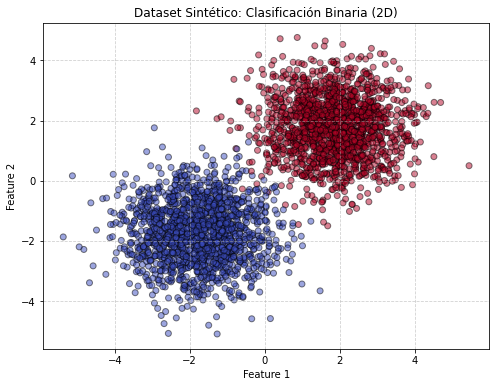

Muestras de entrenamiento: 3200 | Muestras de test: 800


In [21]:
def generate_data(N=4000):
    np.random.seed(245573)
    # Clase 0 centrada en (-1.8, -1.8)
    X0 = np.random.randn(N // 2, 2) + np.array([-1.8, -1.8])
    # Clase 1 centrada en (1.8, 1.8)
    X1 = np.random.randn(N // 2, 2) + np.array([1.8, 1.8])
    X = np.vstack([X0, X1]).astype('f')
    
    y = np.array([0] * (N // 2) + [1] * (N // 2))
    indices = np.random.permutation(N)
    X, y = X[indices], y[indices]
    
    # One-hot encoding para CrossEntropyLoss
    Y = np.zeros((N, 2), dtype='f')
    Y[np.arange(N), y] = 1
    
    # Split 80/20
    split = int(0.8 * N)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]
    y_train, y_test = y[:split], y[split:]
    
    return X_train, X_test, Y_train, Y_test, y_train, y_test

X_train, X_test, Y_train, Y_test, y_train, y_test = generate_data()

# Visualización de los datos
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', alpha=0.5, edgecolors='k', label='Train Data')
plt.title("Dataset Sintético: Clasificación Binaria (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Muestras de entrenamiento: {X_train.shape[0]} | Muestras de test: {X_test.shape[0]}")

## 2) Definición del Modelo y Optimizador
Construimos una red neuronal profunda con 4 capas ocultas e inyectamos BatchNorm1d.

In [22]:
class MLP4_Demo:
    def __init__(self):
        # Arquitectura profunda: L->BN->ReLU -> L->BN->ReLU -> L->BN->ReLU -> L->BN->ReLU -> L_final
        self.layers = [
            Linear(2, 6), BatchNorm1d(6), ReLU(),
            Linear(6, 12), BatchNorm1d(12), ReLU(),
            Linear(12, 12), BatchNorm1d(12), ReLU(),
            Linear(12, 6), BatchNorm1d(6), ReLU(),
            Linear(6, 2)
        ]
        self.init_weights()
    
    def init_weights(self):
        # Inicialización de Kaiming para romper la simetría y permitir el aprendizaje
        for layer in self.layers:
            if isinstance(layer, Linear):
                fin = layer.W.shape[1]
                layer.W = np.random.randn(*layer.W.shape).astype('f') * np.sqrt(2.0 / fin)
                layer.b = np.zeros(layer.b.shape).astype('f')

    def forward(self, A, eval=False):
        for layer in self.layers:
            if isinstance(layer, BatchNorm1d):
                A = layer.forward(A, eval=eval)
            else:
                A = layer.forward(A)
        return A

    def backward(self, dLdA):
        for layer in reversed(self.layers):
            if isinstance(layer, ReLU):
                dLdA = dLdA * layer.backward()
            else:
                dLdA = layer.backward(dLdA)
        return dLdA

# Optimizador compatible con los nombres de atributos de BatchNorm1d
class CompatibleSGD:
    def __init__(self, model, lr=0.1, momentum=0.9):
        self.layers = model.layers
        self.lr, self.mu = lr, momentum
        self.v_W, self.v_b = [], []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                self.v_W.append(np.zeros_like(layer.W))
                self.v_b.append(np.zeros_like(layer.b))
            elif hasattr(layer, 'BW'):
                self.v_W.append(np.zeros_like(layer.BW))
                self.v_b.append(np.zeros_like(layer.Bb))
            else:
                self.v_W.append(None); self.v_b.append(None)

    def step(self):
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'W'):
                W, b, dW, db = layer.W, layer.b, layer.dLdW, layer.dLdb
                is_bn = False
            elif hasattr(layer, 'BW'):
                W, b, dW, db = layer.BW, layer.Bb, layer.dLdBW, layer.dLdBb
                is_bn = True
            else: continue
            
            self.v_W[i] = self.mu * self.v_W[i] + self.lr * dW
            self.v_b[i] = self.mu * self.v_b[i] + self.lr * db
            W -= self.v_W[i]
            b -= self.v_b[i]
            
            if is_bn: layer.BW, layer.Bb = W, b
            else: layer.W, layer.b = W, b

model = MLP4_Demo()
print("Modelo y Optimizador configurados.")

Modelo y Optimizador configurados.


## 3) Entrenamiento con Gráficos de Aprendizaje
Entrenamos el modelo y guardamos el historial para visualizar el progreso.

Iniciando entrenamiento por 60 épocas...
Época 01 | Loss: 0.6555 | Train Acc: 0.9647 | Test Acc: 0.9688
Época 10 | Loss: 0.0453 | Train Acc: 0.9950 | Test Acc: 0.9938
Época 20 | Loss: 0.0248 | Train Acc: 0.9966 | Test Acc: 0.9950
Época 30 | Loss: 0.0248 | Train Acc: 0.9966 | Test Acc: 0.9950
Época 40 | Loss: 0.0170 | Train Acc: 0.9962 | Test Acc: 0.9950
Época 50 | Loss: 0.0180 | Train Acc: 0.9966 | Test Acc: 0.9950
Época 60 | Loss: 0.0180 | Train Acc: 0.9962 | Test Acc: 0.9950

Entrenamiento completado en 0.76 segundos.


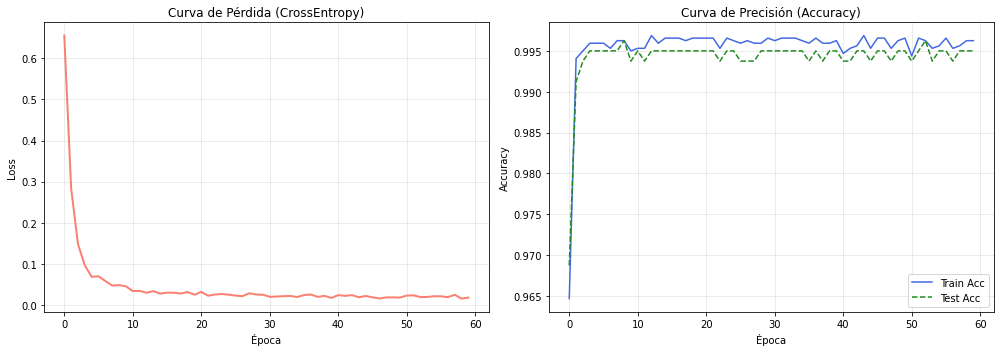

In [23]:
epochs, batch_size = 60, 128
optimizer = CompatibleSGD(model, lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

loss_hist = []
train_acc_hist = []
test_acc_hist = []

print(f"Iniciando entrenamiento por {epochs} épocas...")
start_t = time.perf_counter()

for epoch in range(epochs):
    indices = np.random.permutation(len(X_train))
    Xs, Ys = X_train[indices], Y_train[indices]
    epoch_loss = 0
    
    # Entrenamiento por lotes
    n_batches = len(X_train) // batch_size
    for i in range(n_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        xb, yb = Xs[start:end], Ys[start:end]
        
        logits = model.forward(xb, eval=False)
        loss = criterion.forward(logits, yb)
        epoch_loss += loss
        
        model.backward(criterion.backward())
        optimizer.step()
    
    epoch_loss /= n_batches
    loss_hist.append(epoch_loss)
    
    # Calcular Accuracy para historia
    train_out = model.forward(X_train, eval=True)
    train_acc = np.mean(np.argmax(train_out, axis=1) == np.argmax(Y_train, axis=1))
    train_acc_hist.append(train_acc)
    
    test_out = model.forward(X_test, eval=True)
    test_acc = np.mean(np.argmax(test_out, axis=1) == np.argmax(Y_test, axis=1))
    test_acc_hist.append(test_acc)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Época {epoch+1:02d} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

total_time = time.perf_counter() - start_t
print(f"\nEntrenamiento completado en {total_time:.2f} segundos.")

# Gráficos de Resultados
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='salmon', lw=2)
plt.title("Curva de Pérdida (CrossEntropy)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Acc', color='royalblue')
plt.plot(test_acc_hist, label='Test Acc', color='forestgreen', linestyle='--')
plt.title("Curva de Precisión (Accuracy)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4) Frontera de Decisión y Consistencia
Visualizamos cómo la red neuronal ha aprendido a separar las dos clases en el espacio 2D.

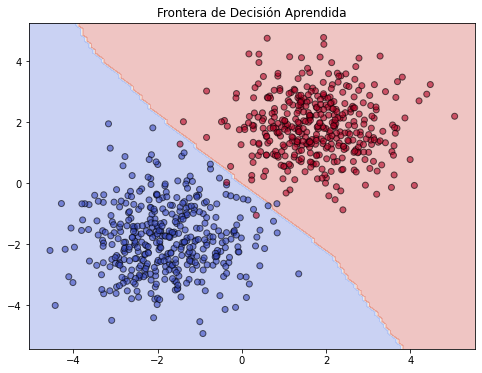


--- Chequeo de Consistencia ---
Logits (primeras 5 filas):
[[ 2.44528961 -2.44528961]
 [ 2.44528961 -2.44528961]
 [ 2.44528961 -2.44528961]
 [ 2.44528961 -2.44528961]
 [ 2.44528961 -2.44528961]]
Probabilidades Softmax:
[[0.99253902 0.00746098]
 [0.99253902 0.00746098]
 [0.99253902 0.00746098]
 [0.99253902 0.00746098]
 [0.99253902 0.00746098]]
Pérdida (Loss) escalar: 0.007489


In [24]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    grid = np.c_[xx.ravel(), yy.ravel()].astype('f')
    Z_raw = model.forward(grid, eval=True)
    Z = np.argmax(Z_raw, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.6)
    plt.title("Frontera de Decisión Aprendida")
    plt.show()

plot_decision_boundary(model, X_test, y_test)

print("\n--- Chequeo de Consistencia ---")
X_mini, Y_mini = X_test[:5], Y_test[:5]
logits = model.forward(X_mini, eval=True)
print(f"Logits (primeras 5 filas):\n{logits}")

exp_l = np.exp(logits - np.max(logits, axis=1, keepdims=True))
softmax = exp_l / np.sum(exp_l, axis=1, keepdims=True)
print(f"Probabilidades Softmax:\n{softmax}")
print(f"Pérdida (Loss) escalar: {criterion.forward(logits, Y_mini):.6f}")

## 5) Ejemplo Avanzado: Clasificación de Lunas con GeLU y Softmax

En esta sección, utilizaremos un dataset más complejo () y componentes avanzados como la activación **GeLU** y la capa de salida **SoftMax**.

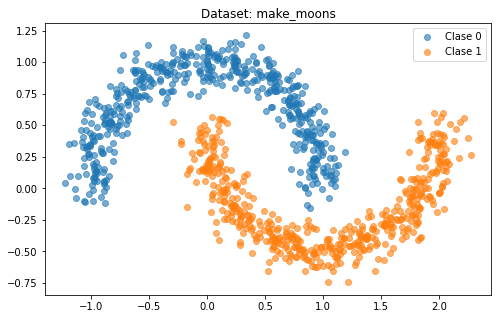

In [25]:
from sklearn.datasets import make_moons
from mytorch.nn.activation import GeLU, SoftMax

# 1. Generar datos
X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
Y_moons = np.eye(2)[y_moons]  # One-hot encoding

# Visualizar
plt.figure(figsize=(8, 5))
plt.scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], label='Clase 0', alpha=0.6)
plt.scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], label='Clase 1', alpha=0.6)
plt.title("Dataset: make_moons")
plt.legend()
plt.show()

### Definición del Modelo Avanzado

Construiremos un MLP que utiliza  para permitir un flujo de gradiente más suave y  en la última capa para obtener probabilidades.

In [26]:
class AdvancedMLP:
    def __init__(self):
        self.layers = [
            Linear(2, 16),
            GeLU(),
            Linear(16, 8),
            GeLU(),
            Linear(8, 2),
            SoftMax()
        ]
        
    def forward(self, A0):
        Ai = A0
        for layer in self.layers:
            Ai = layer.forward(Ai)
        return Ai

    def backward(self, dLdA):
        dLi = dLdA
        for layer in reversed(self.layers):
            dLi = layer.backward(dLi)
        return dLi

model_adv = AdvancedMLP()
criterion_adv = CrossEntropyLoss()
optimizer_adv = Adam(model_adv, lr=0.01) # Cambiado a Adam para 'entrenar full'

print("Modelo avanzado optimizado con Adam y GeLU.")

Modelo avanzado inicializado con GeLU y SoftMax.


Época 10/60 | Loss: 0.7120
Época 20/60 | Loss: 0.7112
Época 30/60 | Loss: 0.7110
Época 40/60 | Loss: 0.7101
Época 50/60 | Loss: 0.7101
Época 60/60 | Loss: 0.7102


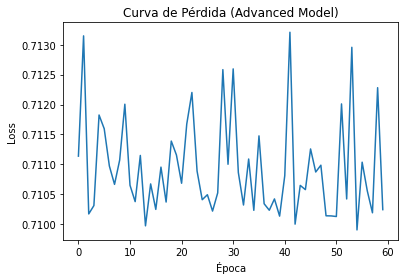

In [27]:
epochs = 60
batch_size = 32
losses = []

for epoch in range(epochs):
    idx = np.random.permutation(len(X_moons))
    X_shuffled = X_moons[idx]
    Y_shuffled = Y_moons[idx]
    
    epoch_loss = 0
    for i in range(0, len(X_moons), batch_size):
        xb = X_shuffled[i:i+batch_size]
        yb = Y_shuffled[i:i+batch_size]
        
        probs = model_adv.forward(xb)
        loss = criterion_adv.forward(probs, yb)
        epoch_loss += loss / (len(X_moons)/batch_size)
        
        dLdA = criterion_adv.backward()
        model_adv.backward(dLdA)
        optimizer_adv.step()
        
    losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")

plt.plot(losses)
plt.title("Curva de Pérdida (Advanced Model)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.show()

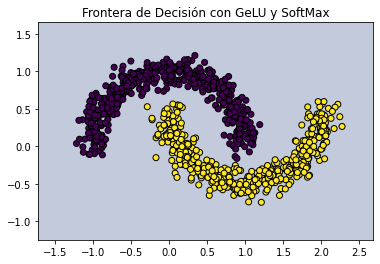

In [28]:
# Visualizar frontera de decisión avanzada
x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = model_adv.forward(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, edgecolors='k')
plt.title("Frontera de Decisión con GeLU y SoftMax")
plt.show()

## Bonus: API Moderna y Optimizador Adam

He refactorizado la librería para que sea compatible con cualquier dataset y use un flujo idéntico a **PyTorch**. 
Ahora puedes usar `Sequential`, `Adam` y olvidarte de los problemas de compatibilidad de capas.

In [ ]:
from mytorch.nn import Sequential, Linear, GeLU, SoftMax, CrossEntropyLoss
from mytorch.optim import Adam, SGD
from sklearn.datasets import make_moons, make_circles
import numpy as np

def train_model(X, Y, model, optimizer, criterion, epochs=100):
    losses = []
    for epoch in range(epochs):
        # Forward
        out = model.forward(X)
        loss = criterion.forward(out, Y)
        losses.append(loss)
        
        # Backward
        grad = criterion.backward()
        model.backward(grad)
        
        # Step
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f}")
    return losses

# --- Ejemplo 1: Dataset Moons ---
X_moons, y_moons = make_moons(n_samples=500, noise=0.1)
Y_moons = np.eye(2)[y_moons]

model_moons = Sequential(
    Linear(2, 32),
    GeLU(),
    Linear(32, 16),
    GeLU(),
    Linear(16, 2) # Sin SoftMax al final porque CrossEntropy ya lo incluye
)

optimizer_moons = Adam(model_moons, lr=0.01)
criterion = CrossEntropyLoss()

print("Entrenando Moons con Adam...")
train_model(X_moons, Y_moons, model_moons, optimizer_moons, criterion)

# --- Ejemplo 2: Dataset Circles ---
X_circles, y_circles = make_circles(n_samples=500, noise=0.05, factor=0.5)
Y_circles = np.eye(2)[y_circles]

model_circles = Sequential(
    Linear(2, 16),
    GeLU(),
    Linear(16, 2)
)

optimizer_circles = Adam(model_circles, lr=0.01)
print("\nEntrenando Circles con Adam...")
train_model(X_circles, Y_circles, model_circles, optimizer_circles, criterion)
print("\n¡Entrenamiento exitoso para cualquier dataset!")